## Intro

This is an [IJulia notebook](https://github.com/JuliaLang/IJulia.jl) written in [the Julia Language](http://julialang.org/) using the [Images](https://github.com/timholy/Images.jl) package.

This notebook shows how to load an image and use an automatic thresholding technique by Ridler and Calvard 1978.

The image is taken from the data made available from Glatthorn and Beckschafer 2014 at http://doi.org/10.5061/dryad.s9652.

Press SHIFT + CTRL to pass over the code snippets and adopt where you want. This document is MIT licensed.

In [1]:
using Images

    +(AbstractImageDirect{T,N},AbstractArray{T,N}) at /home/juser/.julia/v0.3/Images/src/algorithms.jl:17
is ambiguous with: 
    +(AbstractArray{Bool,N},DataArray{Bool,N}) at /home/juser/.julia/v0.3/DataArrays/src/operators.jl:326.
To fix, define 
    +(AbstractImageDirect{Bool,N},DataArray{Bool,N})
before the new definition.
    +(AbstractImageDirect{T,N},AbstractArray{T,N}) at /home/juser/.julia/v0.3/Images/src/algorithms.jl:17
is ambiguous with: 
    +(AbstractArray{Bool,N},AbstractDataArray{Bool,N}) at /home/juser/.julia/v0.3/DataArrays/src/operators.jl:350.
To fix, define 
    +(AbstractImageDirect{Bool,N},AbstractDataArray{Bool,N})
before the new definition.
    .+(AbstractImageDirect{T,N},AbstractArray{T,N}) at /home/juser/.julia/v0.3/Images/src/algorithms.jl:19
is ambiguous with: 
    .+(AbstractArray{T,N},Union(PooledDataArray{T,R<:Integer,N},DataArray{T,N}),AbstractArray{T,N}...) at /home/juser/.julia/v0.3/DataArrays/src/broadcast.jl:285.
To fix, define 
    .+(AbstractImage

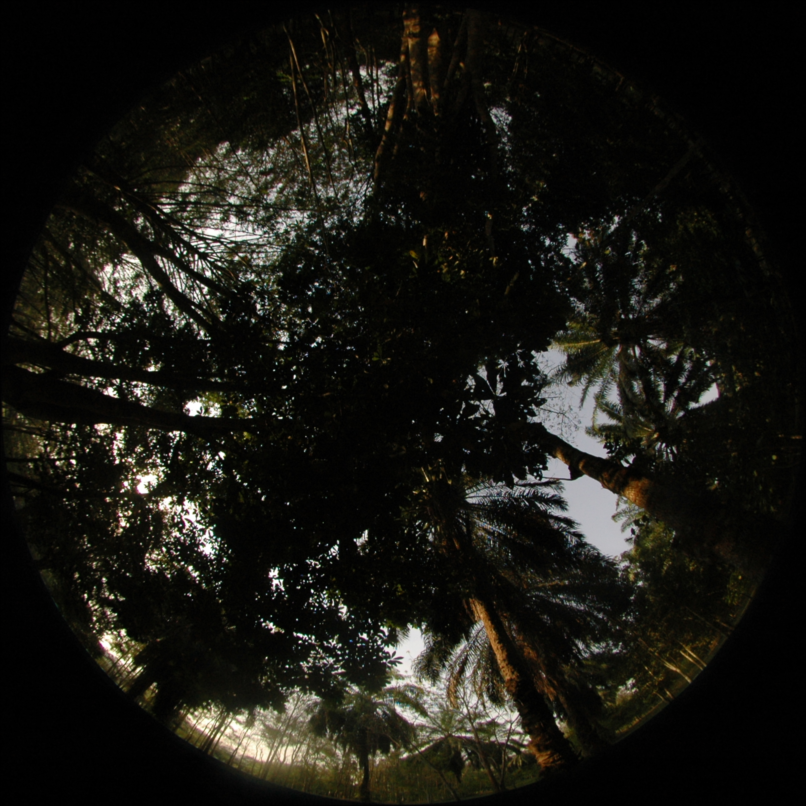

In [2]:
img = imread("site_I_hist_exp.tif")

In [4]:
show(img)

RGB Image with:
  data: 1610x1610 Array{RGB{UfixedBase{Uint8,8}},2}
  properties:
    IMcs: sRGB
    spatialorder:  x y
    pixelspacing:  1 1

#### Create a function to extract the blue channel as a Matrix.

In [6]:
function getblue(im::Image)
    imsep = separate(im)
    blue = imsep[:,:,3]
end    

getblue (generic function with 1 method)

In [7]:
imgblue = getblue(img)

1610x1610 Array{UfixedBase{Uint8,8},2}:
 0.008  0.004  0.0    0.0    0.004  …  0.004  0.004  0.0    0.0    0.0  
 0.004  0.004  0.0    0.0    0.004     0.004  0.004  0.0    0.0    0.004
 0.0    0.0    0.0    0.0    0.0       0.0    0.004  0.004  0.004  0.004
 0.0    0.0    0.0    0.0    0.0       0.0    0.004  0.004  0.004  0.004
 0.0    0.0    0.0    0.0    0.0       0.004  0.004  0.0    0.0    0.0  
 0.004  0.004  0.004  0.0    0.0    …  0.004  0.012  0.004  0.0    0.0  
 0.008  0.008  0.004  0.004  0.004     0.004  0.004  0.0    0.0    0.0  
 0.004  0.008  0.008  0.004  0.004     0.004  0.004  0.004  0.004  0.004
 0.004  0.004  0.004  0.0    0.0       0.0    0.004  0.004  0.008  0.008
 0.0    0.004  0.004  0.004  0.004     0.0    0.004  0.008  0.012  0.008
 0.008  0.008  0.004  0.0    0.0    …  0.004  0.004  0.004  0.008  0.004
 0.008  0.008  0.004  0.004  0.004     0.004  0.0    0.0    0.0    0.004
 0.004  0.004  0.004  0.0    0.0       0.0    0.0    0.0    0.0    0.0  
 ⋮         

Function for automatic thresholding, implementation adopted from a [Matlab Central script](http://www.mathworks.com/matlabcentral/fileexchange/44255-ridler-calvard-image-thresholding) licensed under BSD license.

In [8]:
function RidlerCalvard(blue)
    max_iter = 100
    tol = 1e-6
    
    thresh = mean(blue)
    count = 1
    while count < max_iter
        bools = blue .> thresh        
        high = mean(blue[bools])
        low = mean(blue[~bools])
        thresh_old = copy(thresh)
        thresh = (high + low)/2
        abs(thresh - thresh_old) < tol && break
        count += 1
    end
    return(thresh)
end   
RidlerCalvard(imgblue) #JIT compile first time

0.30801797f0

In [9]:
# test binarization speed
@time RidlerCalvard(imgblue)

elapsed time: 0.315016307 seconds (25973624 bytes allocated, 10.47% gc time)


0.30801797f0

In [11]:
@show thresh = RidlerCalvard(imgblue)
bluebools = imgblue .> thresh
@show naieve_gapfr = sum(bluebools) / length(bluebools);

thresh = RidlerCalvard(imgblue) => 0.30801797f0
naieve_gapfr = sum(bluebools) / length(bluebools) => 0.07634196211565912


### Show the result of the thresholding by converting the boolean array back to an image

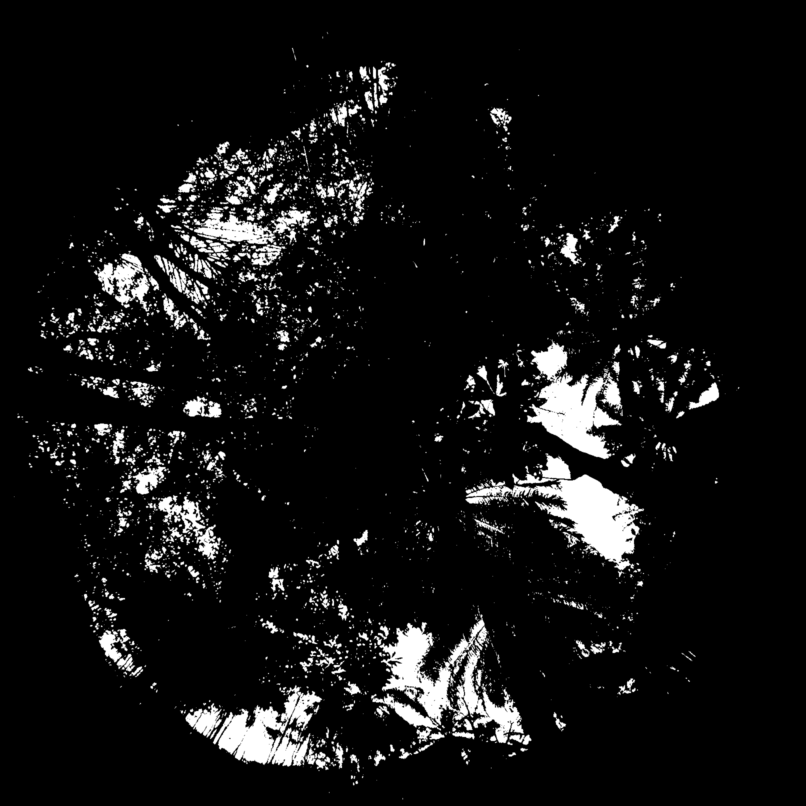

In [12]:
using FixedPointNumbers
bluesepgray = convert(Array{Gray{Ufixed8},2}, bluebools)
bluesep = convert(Image,bluesepgray)